# Morphing Emojis

In [1]:
from controllable_nca.experiments.morphing_image.trainer import MorphingImageNCATrainer
from controllable_nca.experiments.morphing_image.emoji_dataset import EmojiDataset
from controllable_nca.nca import ControllableNCA

import torch

In [2]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange

from controllable_nca.dataset import NCADataset
from controllable_nca.utils import load_emoji, rgb


class EmojiDataset(NCADataset):
    # EMOJI = '🦎😀💥'
    EMOJI = "🦎😀💥👁🐠🦋🐞🕸🥨🎄"
    # EMOJI = "🦎😀👁🕸🥨🎄"

    digits = [
        "0030",  # 0
        "0031",  # 1
        "0032",  # 2
        "0033",  # 3
        "0034",  # 4
        "0035",  # 5
        "0036",  # 6
        "0037",  # 7
        "0038",  # 8
        "0039",  # 9
    ]

    def __init__(self, image_size=64, thumbnail_size=32, use_one_hot: bool = False):
        emojis = torch.stack(
            [load_emoji(e, image_size, thumbnail_size) for e in EmojiDataset.EMOJI],
            dim=0,
        )
        self.emojis = emojis
        self.num_samples = len(self)
        self._target_size = self.emojis.size()[-3:]

    def num_goals(self):
        return self.emojis.size(0)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.emojis[idx : idx + 1].clone(), idx
        return self.emojis[idx].clone(), idx

    def __len__(self):
        return self.emojis.size(0)

    def target_size(self):
        if self._target_size is not None:
            return self._target_size
        self._target_size = self.emojis.size()[-3:]
        return self._target_size

    def to(self, device: torch.device):
        self.emojis = self.emojis.to(device)

    def visualize(self, idx=0):
        self.plot_img(self.emojis[idx : idx + 1])

    def plot_img(self, img):
        with torch.no_grad():
            rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
        rgb_image = rearrange(rgb_image, "c w h -> w h c")
        _ = plt.imshow(rgb_image)
        plt.show()


In [3]:
dataset = EmojiDataset(image_size=64, thumbnail_size=40)

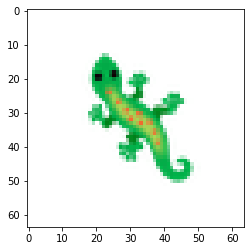

In [4]:
dataset.visualize(0)

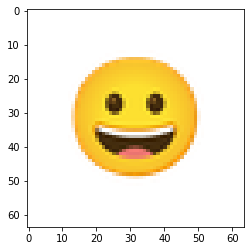

In [5]:
dataset.visualize(1)

### Make NCA

In [6]:
dataset.target_size()

torch.Size([4, 64, 64])

In [14]:
from typing import Optional, Tuple  # noqa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding

from controllable_nca.utils import build_conv2d_net


class DeepEncoder(nn.Module):
    def __init__(self, num_embeddings: int, out_channels: int):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding = Embedding(num_embeddings, 32)
        self.encoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_channels, bias=False),
        )

    def forward(self, indices):
        embeddings = self.encoder(self.embedding(indices))
        return embeddings



In [15]:
NUM_HIDDEN_CHANNELS = 16

In [16]:
encoder = DeepEncoder(dataset.num_goals(), NUM_HIDDEN_CHANNELS)

nca =  ControllableNCA(num_goals=dataset.num_goals(), use_image_encoder=False, encoder=encoder, target_shape=dataset.target_size(), living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS, cell_fire_rate=0.5)

In [17]:
device = torch.device('cuda')
nca = nca.to(device)
dataset.to(device)

In [18]:
trainer = MorphingImageNCATrainer(nca, dataset, nca_steps=[48, 96], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=1024)

Writing to tensorboard_logs/2022-02-25 03:23:41.732852


In [19]:
nca

ControllableNCA(
  (perception_net): Conv2d(21, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=21, bias=False)
  (update_net): UpdateNet(
    (out): Sequential(
      (0): Conv2d(63, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 21, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (encoder): DeepEncoder(
    (embedding): Embedding(10, 32)
    (encoder): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=False)
    )
  )
)

In [20]:
trainer.train(batch_size=8, epochs=100000)

loss:0.008732454851269722--log10loss:-2.058366601843431--clip_loss:0.0--perception_net.weight_grad:-4.318743705749512--update_net.out.0.weight_grad:-0.9856123328208923--update_net.out.0.bias_grad:-0.22372305393218994--update_net.out.2.weight_grad:-1.008923053741455--update_net.out.2.bias_grad:-0.031099557876586914--update_net.out.4.weight_grad:7.169270038604736--encoder.embedding.weight_grad:0.6652339100837708--en


In [22]:
from controllable_nca.experiments.morphing_image.visualizer import MorphingImageVisualizer

In [29]:
import matplotlib.pyplot as plt
from einops import rearrange

def get_rotating_images(cell_fire_rate = 1.0):
    with torch.no_grad():
        nca.cell_fire_rate = cell_fire_rate
        fig = plt.figure(figsize=(24, 24))
        # fig.suptitle('test title', fontsize=20)
        columns = 5
        rows = 4        # seed

        seed = nca.generate_seed(1).to(trainer.device)
#         fig.add_subplot(rows,columns,1)
#         plt.imshow(rearrange(trainer.to_rgb(seed)[0], 'c h w -> h w c'))        # center
    
        _, goal = trainer.target_dataset[1]
        # center_goal = torch.tensor(1, device=trainer.device)
        out = nca.grow(seed, 96, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,1)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # right

        _, goal = trainer.target_dataset[2]
        out = nca.grow(out, 8, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,2)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,3)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,4)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 64, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,5)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        _, goal = trainer.target_dataset[5]

        fig.add_subplot(rows,columns,6)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 8, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,7)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,8)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,9)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 64, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,10)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        _, goal = trainer.target_dataset[8]

        fig.add_subplot(rows,columns,11)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 8, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,12)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,13)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,14)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 64, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,15)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        _, goal = trainer.target_dataset[7]

        fig.add_subplot(rows,columns,16)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 8, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,17)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,18)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 16, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,19)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        out = nca.grow(out, 64, torch.tensor(goal, device=trainer.device))
        fig.add_subplot(rows,columns,20)
        plt.imshow(rearrange(trainer.to_rgb(out)[0], 'c h w -> h w c'))        # up

        plt.subplots_adjust(bottom=0.5, top=0.8, hspace=0)
        plt.show()

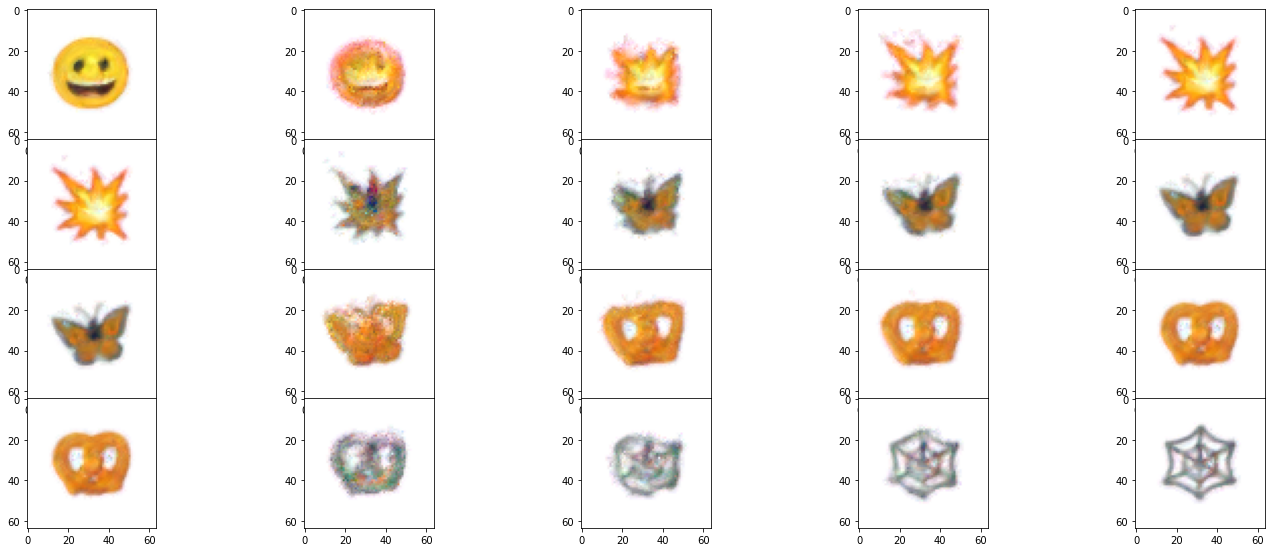

In [32]:
get_rotating_images(0.5)

In [34]:
from threading import Event, Thread

import cv2
import numpy as np
import torch
from einops import rearrange
from ipycanvas import Canvas, hold_canvas  # noqa
from ipywidgets import Button, HBox, VBox

from controllable_nca.utils import create_2d_circular_mask, rgb


def to_numpy_rgb(x, use_rgb=False):
    return rearrange(
        np.squeeze(rgb(x, use_rgb).detach().cpu().numpy()), "c x y -> x y c"
    )


class MorphingImageVisualizer:
    def __init__(
        self,
        trainer,
        image_size,
        rgb: bool = False,
        canvas_scale=5,
        damage_radius: int = 5,
    ):
        self.trainer = trainer
        self.current_state = None
        self.current_embedding = None

        self.image_size = image_size
        self.rgb = rgb
        self.canvas_scale = canvas_scale
        self.canvas_size = self.image_size * self.canvas_scale

        self.canvas = Canvas(width=self.canvas_size, height=self.canvas_size)
        self.canvas.on_mouse_down(self.handle_mouse_down)
        self.stopped = Event()

        # self.current_embedding, _ = trainer.target_dataset[0]
        self.current_embedding = torch.tensor(0, device=self.trainer.device)

        self.device = self.trainer.device
        self.damage_radius = damage_radius
        self.current_state = self.trainer.nca.generate_seed(1).to(self.device)

        def button_fn(class_num):
            def start(btn):
                # self.current_embedding, _ = trainer.target_dataset[class_num]
                self.current_embedding = torch.tensor(class_num, device=self.trainer.device)
                if self.stopped.isSet():
                    self.stopped.clear()
                    Thread(target=self.loop).start()

            return start

        button_list = []
        for i in range(len(self.trainer.target_dataset.EMOJI)):
            button_list.append(Button(description=self.trainer.target_dataset.EMOJI[i]))
            button_list[-1].on_click(button_fn(i))

        self.vbox = VBox(button_list)

        self.stop_btn = Button(description="Stop")

        def stop(btn):
            if not self.stopped.isSet():
                self.stopped.set()

        self.stop_btn.on_click(stop)

    def handle_mouse_down(self, xpos, ypos):
        in_x = int(xpos / self.canvas_scale)
        in_y = int(ypos / self.canvas_scale)

        mask = create_2d_circular_mask(
            self.image_size,
            self.image_size,
            (in_x, in_y),
            radius=self.damage_radius,
        )
        self.current_state[0][:, mask] *= 0.0

    def draw_image(self, rgb):
        with hold_canvas(self.canvas):
            rgb = np.squeeze(rearrange(rgb, "b c w h -> b w h c"))
            self.canvas.clear()  # Clear the old animation step
            self.canvas.put_image_data(
                cv2.resize(
                    rgb * 255.0,
                    (self.canvas_size, self.canvas_size),
                    interpolation=cv2.INTER_NEAREST,
                ),
                0,
                0,
            )

    def loop(self):
        with torch.no_grad():
            self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
            while not self.stopped.wait(0.02):  # the first call is in `interval` secs
                # update_particle_locations()
                self.draw_image(self.trainer.to_rgb(self.current_state))
                self.current_state = self.trainer.nca.grow(
                    self.current_state, 1, self.current_embedding
                )

    def visualize(self):
        Thread(target=self.loop).start()
        display(self.canvas, HBox([self.stop_btn, self.vbox]))  # noqa


In [35]:
viz = MorphingImageVisualizer(trainer, 64)

In [36]:
viz.visualize()

Canvas(height=320, width=320)